In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, concatenate
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [45]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5, 7"

In [3]:
dataset = pd.read_csv('../../../data/pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [4]:
print(dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['pollution']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (43800, 1)
stages_supervised.shape: (43705, 96)


In [7]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
2010-01-05 01:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2010-01-05 02:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
2010-01-05 03:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
2010-01-05 04:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,164.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30 20:00:00,349.0,327.0,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
2014-12-30 21:00:00,327.0,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,264.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
2014-12-30 22:00:00,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,264.0,221.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0


#### Prior unknown covariates (6)

In [8]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [9]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [10]:
prior_known = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (43800, 10)
prior_known_supervised.shape: (43705, 960)


In [11]:
# prior_known_supervised

### N_out, N_in, K

In [12]:
past_cov = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (43705, 960)


In [13]:
# past_cov_supervised  # 6 + 9 = 15 features

In [14]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [15]:
# past_ws_supervised  # 4

In [16]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [17]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [18]:
# past_cov_ws_supervised

In [19]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23),shift_prior_known_supervised_var10(t+23)
0,-7.0,-6.0,1027.0,58.56,4.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-8.0,-6.0,1026.0,61.69,5.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-8.0,-7.0,1026.0,65.71,6.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-8.0,-7.0,1025.0,68.84,7.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-8.0,-7.0,1024.0,72.86,8.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-13.0,3.0,1017.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-13.0,1.0,1017.0,1.78,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-10.0,2.0,1017.0,2.67,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-10.0,-2.0,1017.0,3.12,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [21]:
# shift_prior_known_past_cov_ws_supervised

In [22]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
1,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
3,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
4,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,26.0,20.0,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43701,20.0,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43702,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,8.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43703,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,8.0,8.0,...,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Concatenation

In [23]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43705, 1536)


### Train & Test set

In [24]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 34964


In [25]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

1512

### Normalization

In [26]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (34964, 1512) (34964, 24) (8741, 1512) (8741, 24)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (34964, 72, 21) (34964, 24) (8741, 72, 21) (8741, 24)


### Model

In [42]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

### 3 rnn skip connection
x = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x_merge1 = concatenate([model_input, x])

x = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x_merge1)

x_merge2 = concatenate([model_input, x])

x = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x_merge2)

x_merge3 = concatenate([model_input, x])

x = layers.SimpleRNN(16, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x_merge3)

merge = concatenate([model_input, x])
merge = layers.Flatten()(merge)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(train_y.shape[1])(x)

model_rnn = Model(model_input, x)
model_rnn.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 72, 21)]     0                                            
__________________________________________________________________________________________________
simple_rnn_29 (SimpleRNN)       (None, 72, 128)      19200       input_9[0][0]                    
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 72, 149)      0           input_9[0][0]                    
                                                                 simple_rnn_29[0][0]              
__________________________________________________________________________________________________
simple_rnn_30 (SimpleRNN)       (None, 72, 64)       13696       concatenate_28[0][0]       

Epoch 1/6000

Epoch 00001: val_mae improved from inf to 0.08523, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/69 - 12s - loss: 0.2155 - mae: 0.0845 - val_loss: 0.1870 - val_mae: 0.0852
Epoch 2/6000

Epoch 00002: val_mae improved from 0.08523 to 0.07649, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/69 - 12s - loss: 0.1580 - mae: 0.0550 - val_loss: 0.1477 - val_mae: 0.0765
Epoch 3/6000

Epoch 00003: val_mae improved from 0.07649 to 0.06883, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/69 - 12s - loss: 0.1291 - mae: 0.0493 - val_loss: 0.1231 - val_mae: 0.0688
Epoch 4/6000

Epoch 00004: val_mae improved from 0.06883 to 0.06768, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/69 - 12s - loss: 0.1083 - mae: 0.0463 - val_loss: 0.1044 - val_mae: 0.0677
Epoch 5/6000

Epoch 00005: val_mae improved from 0.06768 to 0.06450, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/69 - 12s - loss: 0.0923 - mae: 0.0

Epoch 48/6000

Epoch 00048: val_mae improved from 0.05148 to 0.05083, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/69 - 12s - loss: 0.0057 - mae: 0.0359 - val_loss: 0.0089 - val_mae: 0.0508
Epoch 49/6000

Epoch 00049: val_mae did not improve from 0.05083
69/69 - 12s - loss: 0.0056 - mae: 0.0359 - val_loss: 0.0093 - val_mae: 0.0566
Epoch 50/6000

Epoch 00050: val_mae did not improve from 0.05083
69/69 - 12s - loss: 0.0055 - mae: 0.0361 - val_loss: 0.0090 - val_mae: 0.0540
Epoch 51/6000

Epoch 00051: val_mae did not improve from 0.05083
69/69 - 12s - loss: 0.0054 - mae: 0.0361 - val_loss: 0.0086 - val_mae: 0.0518
Epoch 52/6000

Epoch 00052: val_mae improved from 0.05083 to 0.05072, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/69 - 12s - loss: 0.0053 - mae: 0.0359 - val_loss: 0.0084 - val_mae: 0.0507
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.05072
69/69 - 12s - loss: 0.0052 - mae: 0.0358 - val_loss: 0.0086 - val_mae: 0.0510
Epoch 54


Epoch 00101: val_mae did not improve from 0.04923
69/69 - 12s - loss: 0.0039 - mae: 0.0347 - val_loss: 0.0073 - val_mae: 0.0529
Epoch 102/6000

Epoch 00102: val_mae did not improve from 0.04923
69/69 - 12s - loss: 0.0039 - mae: 0.0347 - val_loss: 0.0074 - val_mae: 0.0537
Epoch 103/6000

Epoch 00103: val_mae did not improve from 0.04923
69/69 - 12s - loss: 0.0039 - mae: 0.0349 - val_loss: 0.0070 - val_mae: 0.0499
Epoch 104/6000

Epoch 00104: val_mae did not improve from 0.04923
69/69 - 12s - loss: 0.0039 - mae: 0.0348 - val_loss: 0.0075 - val_mae: 0.0538
Epoch 105/6000

Epoch 00105: val_mae did not improve from 0.04923
69/69 - 12s - loss: 0.0039 - mae: 0.0345 - val_loss: 0.0070 - val_mae: 0.0496
Epoch 106/6000

Epoch 00106: val_mae did not improve from 0.04923
69/69 - 12s - loss: 0.0039 - mae: 0.0346 - val_loss: 0.0079 - val_mae: 0.0581
Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.04923
69/69 - 12s - loss: 0.0040 - mae: 0.0352 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 1

Epoch 156/6000

Epoch 00156: val_mae did not improve from 0.04842
69/69 - 12s - loss: 0.0038 - mae: 0.0341 - val_loss: 0.0070 - val_mae: 0.0501
Epoch 157/6000

Epoch 00157: val_mae did not improve from 0.04842
69/69 - 12s - loss: 0.0038 - mae: 0.0341 - val_loss: 0.0068 - val_mae: 0.0492
Epoch 158/6000

Epoch 00158: val_mae did not improve from 0.04842
69/69 - 12s - loss: 0.0038 - mae: 0.0343 - val_loss: 0.0069 - val_mae: 0.0502
Epoch 159/6000

Epoch 00159: val_mae did not improve from 0.04842
69/69 - 12s - loss: 0.0037 - mae: 0.0340 - val_loss: 0.0071 - val_mae: 0.0515
Epoch 160/6000

Epoch 00160: val_mae did not improve from 0.04842
69/69 - 12s - loss: 0.0038 - mae: 0.0343 - val_loss: 0.0068 - val_mae: 0.0489
Epoch 161/6000

Epoch 00161: val_mae did not improve from 0.04842
69/69 - 12s - loss: 0.0038 - mae: 0.0342 - val_loss: 0.0072 - val_mae: 0.0499
Epoch 162/6000

Epoch 00162: val_mae did not improve from 0.04842
69/69 - 12s - loss: 0.0038 - mae: 0.0348 - val_loss: 0.0070 - val_mae:

Epoch 211/6000

Epoch 00211: val_mae did not improve from 0.04825
69/69 - 11s - loss: 0.0037 - mae: 0.0338 - val_loss: 0.0069 - val_mae: 0.0505
Epoch 212/6000

Epoch 00212: val_mae did not improve from 0.04825
69/69 - 11s - loss: 0.0037 - mae: 0.0337 - val_loss: 0.0070 - val_mae: 0.0501
Epoch 213/6000

Epoch 00213: val_mae did not improve from 0.04825
69/69 - 10s - loss: 0.0037 - mae: 0.0337 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 214/6000

Epoch 00214: val_mae did not improve from 0.04825
69/69 - 10s - loss: 0.0037 - mae: 0.0339 - val_loss: 0.0069 - val_mae: 0.0488
Epoch 215/6000

Epoch 00215: val_mae did not improve from 0.04825
69/69 - 11s - loss: 0.0036 - mae: 0.0336 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 216/6000

Epoch 00216: val_mae did not improve from 0.04825
69/69 - 10s - loss: 0.0037 - mae: 0.0338 - val_loss: 0.0069 - val_mae: 0.0503
Epoch 217/6000

Epoch 00217: val_mae improved from 0.04825 to 0.04822, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/

Epoch 267/6000

Epoch 00267: val_mae did not improve from 0.04802
69/69 - 10s - loss: 0.0036 - mae: 0.0337 - val_loss: 0.0070 - val_mae: 0.0490
Epoch 268/6000

Epoch 00268: val_mae did not improve from 0.04802
69/69 - 10s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0071 - val_mae: 0.0494
Epoch 269/6000

Epoch 00269: val_mae did not improve from 0.04802
69/69 - 10s - loss: 0.0036 - mae: 0.0336 - val_loss: 0.0070 - val_mae: 0.0495
Epoch 270/6000

Epoch 00270: val_mae did not improve from 0.04802
69/69 - 11s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0069 - val_mae: 0.0490
Epoch 271/6000

Epoch 00271: val_mae did not improve from 0.04802
69/69 - 10s - loss: 0.0036 - mae: 0.0333 - val_loss: 0.0073 - val_mae: 0.0533
Epoch 272/6000

Epoch 00272: val_mae did not improve from 0.04802
69/69 - 11s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0070 - val_mae: 0.0488
Epoch 273/6000

Epoch 00273: val_mae improved from 0.04802 to 0.04786, saving model to saved_model/rnn_shift_anyday_24h_4layer_sc.h5
69/

Epoch 339/6000

Epoch 00339: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0504
Epoch 340/6000

Epoch 00340: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0036 - mae: 0.0334 - val_loss: 0.0069 - val_mae: 0.0497
Epoch 341/6000

Epoch 00341: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0036 - mae: 0.0335 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 342/6000

Epoch 00342: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0036 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0486
Epoch 343/6000

Epoch 00343: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0068 - val_mae: 0.0487
Epoch 344/6000

Epoch 00344: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 345/6000

Epoch 00345: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0036 - mae: 0.0336 - val_loss: 0.0068 - val_mae:

Epoch 396/6000

Epoch 00396: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0036 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0519
Epoch 397/6000

Epoch 00397: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0070 - val_mae: 0.0494
Epoch 398/6000

Epoch 00398: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0036 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0498
Epoch 399/6000

Epoch 00399: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0036 - mae: 0.0335 - val_loss: 0.0070 - val_mae: 0.0495
Epoch 400/6000

Epoch 00400: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0036 - mae: 0.0336 - val_loss: 0.0070 - val_mae: 0.0498
Epoch 401/6000

Epoch 00401: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0036 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0494
Epoch 402/6000

Epoch 00402: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0070 - val_mae:

Epoch 453/6000

Epoch 00453: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0069 - val_mae: 0.0484
Epoch 454/6000

Epoch 00454: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0496
Epoch 455/6000

Epoch 00455: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 456/6000

Epoch 00456: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0075 - val_mae: 0.0536
Epoch 457/6000

Epoch 00457: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 458/6000

Epoch 00458: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0070 - val_mae: 0.0503
Epoch 459/6000

Epoch 00459: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0072 - val_mae:

Epoch 510/6000

Epoch 00510: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0074 - val_mae: 0.0524
Epoch 511/6000

Epoch 00511: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0036 - mae: 0.0337 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 512/6000

Epoch 00512: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0073 - val_mae: 0.0521
Epoch 513/6000

Epoch 00513: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0499
Epoch 514/6000

Epoch 00514: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0492
Epoch 515/6000

Epoch 00515: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0069 - val_mae: 0.0479
Epoch 516/6000

Epoch 00516: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0036 - mae: 0.0336 - val_loss: 0.0071 - val_mae:

Epoch 567/6000

Epoch 00567: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0500
Epoch 568/6000

Epoch 00568: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0484
Epoch 569/6000

Epoch 00569: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 570/6000

Epoch 00570: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0335 - val_loss: 0.0070 - val_mae: 0.0496
Epoch 571/6000

Epoch 00571: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0069 - val_mae: 0.0501
Epoch 572/6000

Epoch 00572: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0506
Epoch 573/6000

Epoch 00573: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0068 - val_mae:

Epoch 624/6000

Epoch 00624: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0330 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 625/6000

Epoch 00625: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0075 - val_mae: 0.0538
Epoch 626/6000

Epoch 00626: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0335 - val_loss: 0.0069 - val_mae: 0.0484
Epoch 627/6000

Epoch 00627: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0330 - val_loss: 0.0072 - val_mae: 0.0526
Epoch 628/6000

Epoch 00628: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0069 - val_mae: 0.0486
Epoch 629/6000

Epoch 00629: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0483
Epoch 630/6000

Epoch 00630: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0070 - val_mae:

Epoch 681/6000

Epoch 00681: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0498
Epoch 682/6000

Epoch 00682: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0485
Epoch 683/6000

Epoch 00683: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0488
Epoch 684/6000

Epoch 00684: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0491
Epoch 685/6000

Epoch 00685: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0075 - val_mae: 0.0523
Epoch 686/6000

Epoch 00686: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0067 - val_mae: 0.0482
Epoch 687/6000

Epoch 00687: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0070 - val_mae:

Epoch 738/6000

Epoch 00738: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0077 - val_mae: 0.0562
Epoch 739/6000

Epoch 00739: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0489
Epoch 740/6000

Epoch 00740: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 741/6000

Epoch 00741: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0481
Epoch 742/6000

Epoch 00742: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0486
Epoch 743/6000

Epoch 00743: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0489
Epoch 744/6000

Epoch 00744: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0071 - val_mae:

Epoch 795/6000

Epoch 00795: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0071 - val_mae: 0.0502
Epoch 796/6000

Epoch 00796: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 797/6000

Epoch 00797: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0499
Epoch 798/6000

Epoch 00798: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 799/6000

Epoch 00799: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0488
Epoch 800/6000

Epoch 00800: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0492
Epoch 801/6000

Epoch 00801: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0072 - val_mae:

Epoch 905/6000

Epoch 00905: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0069 - val_mae: 0.0485
Epoch 906/6000

Epoch 00906: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0495
Epoch 907/6000

Epoch 00907: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0502
Epoch 908/6000

Epoch 00908: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0485
Epoch 909/6000

Epoch 00909: val_mae did not improve from 0.04786
69/69 - 11s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0487
Epoch 910/6000

Epoch 00910: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 911/6000

Epoch 00911: val_mae did not improve from 0.04786
69/69 - 10s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0070 - val_mae:

Epoch 962/6000

Epoch 00962: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 963/6000

Epoch 00963: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 964/6000

Epoch 00964: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0035 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0494
Epoch 965/6000

Epoch 00965: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 966/6000

Epoch 00966: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 967/6000

Epoch 00967: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0490
Epoch 968/6000

Epoch 00968: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0069 - val_mae:

Epoch 1019/6000

Epoch 01019: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0074 - val_mae: 0.0533
Epoch 1020/6000

Epoch 01020: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0035 - mae: 0.0333 - val_loss: 0.0071 - val_mae: 0.0514
Epoch 1021/6000

Epoch 01021: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0505
Epoch 1022/6000

Epoch 01022: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0482
Epoch 1023/6000

Epoch 01023: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0071 - val_mae: 0.0504
Epoch 1024/6000

Epoch 01024: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0486
Epoch 1025/6000

Epoch 01025: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0070 - v

Epoch 1076/6000

Epoch 01076: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 1077/6000

Epoch 01077: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0480
Epoch 1078/6000

Epoch 01078: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0516
Epoch 1079/6000

Epoch 01079: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0518
Epoch 1080/6000

Epoch 01080: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 1081/6000

Epoch 01081: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0075 - val_mae: 0.0542
Epoch 1082/6000

Epoch 01082: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0069 - v

Epoch 1133/6000

Epoch 01133: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0485
Epoch 1134/6000

Epoch 01134: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0492
Epoch 1135/6000

Epoch 01135: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0069 - val_mae: 0.0500
Epoch 1136/6000

Epoch 01136: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0067 - val_mae: 0.0480
Epoch 1137/6000

Epoch 01137: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0077 - val_mae: 0.0565
Epoch 1138/6000

Epoch 01138: val_mae did not improve from 0.04770
69/69 - 11s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 1139/6000

Epoch 01139: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0073 - v

Epoch 1190/6000

Epoch 01190: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0067 - val_mae: 0.0483
Epoch 1191/6000

Epoch 01191: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0326 - val_loss: 0.0077 - val_mae: 0.0579
Epoch 1192/6000

Epoch 01192: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 1193/6000

Epoch 01193: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 1194/6000

Epoch 01194: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 1195/6000

Epoch 01195: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 1196/6000

Epoch 01196: val_mae did not improve from 0.04770
69/69 - 10s - loss: 0.0035 - mae: 0.0334 - val_loss: 0.0070 - v


Epoch 01246: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0071 - val_mae: 0.0519
Epoch 1247/6000

Epoch 01247: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0071 - val_mae: 0.0515
Epoch 1248/6000

Epoch 01248: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0516
Epoch 1249/6000

Epoch 01249: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 1250/6000

Epoch 01250: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0500
Epoch 1251/6000

Epoch 01251: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0068 - val_mae: 0.0487
Epoch 1252/6000

Epoch 01252: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0488
E

Epoch 1303/6000

Epoch 01303: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0496
Epoch 1304/6000

Epoch 01304: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0486
Epoch 1305/6000

Epoch 01305: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0484
Epoch 1306/6000

Epoch 01306: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0506
Epoch 1307/6000

Epoch 01307: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0508
Epoch 1308/6000

Epoch 01308: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0496
Epoch 1309/6000

Epoch 01309: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0069 - v

Epoch 1360/6000

Epoch 01360: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0067 - val_mae: 0.0484
Epoch 1361/6000

Epoch 01361: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0498
Epoch 1362/6000

Epoch 01362: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0084 - val_mae: 0.0597
Epoch 1363/6000

Epoch 01363: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 1364/6000

Epoch 01364: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 1365/6000

Epoch 01365: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 1366/6000

Epoch 01366: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0325 - val_loss: 0.0068 - v

Epoch 1417/6000

Epoch 01417: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0490
Epoch 1418/6000

Epoch 01418: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0096 - val_mae: 0.0674
Epoch 1419/6000

Epoch 01419: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 1420/6000

Epoch 01420: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0496
Epoch 1421/6000

Epoch 01421: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 1422/6000

Epoch 01422: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0508
Epoch 1423/6000

Epoch 01423: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0068 - v

Epoch 1474/6000

Epoch 01474: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0068 - val_mae: 0.0490
Epoch 1475/6000

Epoch 01475: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0501
Epoch 1476/6000

Epoch 01476: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0068 - val_mae: 0.0486
Epoch 1477/6000

Epoch 01477: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0068 - val_mae: 0.0506
Epoch 1478/6000

Epoch 01478: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0072 - val_mae: 0.0496
Epoch 1479/6000

Epoch 01479: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0479
Epoch 1480/6000

Epoch 01480: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0068 - v

Epoch 1531/6000

Epoch 01531: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0488
Epoch 1532/6000

Epoch 01532: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0075 - val_mae: 0.0544
Epoch 1533/6000

Epoch 01533: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0504
Epoch 1534/6000

Epoch 01534: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0511
Epoch 1535/6000

Epoch 01535: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0067 - val_mae: 0.0482
Epoch 1536/6000

Epoch 01536: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 1537/6000

Epoch 01537: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0068 - v

Epoch 1597/6000

Epoch 01597: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0069 - val_mae: 0.0485
Epoch 1598/6000

Epoch 01598: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0489
Epoch 1599/6000

Epoch 01599: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0508
Epoch 1600/6000

Epoch 01600: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0514
Epoch 1601/6000

Epoch 01601: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0491
Epoch 1602/6000

Epoch 01602: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0484
Epoch 1603/6000

Epoch 01603: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0068 - v

Epoch 1654/6000

Epoch 01654: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0502
Epoch 1655/6000

Epoch 01655: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 1656/6000

Epoch 01656: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0497
Epoch 1657/6000

Epoch 01657: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0493
Epoch 1658/6000

Epoch 01658: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0070 - val_mae: 0.0492
Epoch 1659/6000

Epoch 01659: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0491
Epoch 1660/6000

Epoch 01660: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0069 - v

Epoch 1711/6000

Epoch 01711: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0503
Epoch 1712/6000

Epoch 01712: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0488
Epoch 1713/6000

Epoch 01713: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0490
Epoch 1714/6000

Epoch 01714: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0489
Epoch 1715/6000

Epoch 01715: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0496
Epoch 1716/6000

Epoch 01716: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0068 - val_mae: 0.0497
Epoch 1717/6000

Epoch 01717: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0068 - v

Epoch 1768/6000

Epoch 01768: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0485
Epoch 1769/6000

Epoch 01769: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0071 - val_mae: 0.0521
Epoch 1770/6000

Epoch 01770: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0516
Epoch 1771/6000

Epoch 01771: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0068 - val_mae: 0.0486
Epoch 1772/6000

Epoch 01772: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0077 - val_mae: 0.0552
Epoch 1773/6000

Epoch 01773: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0485
Epoch 1774/6000

Epoch 01774: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0069 - v

Epoch 1825/6000

Epoch 01825: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 1826/6000

Epoch 01826: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0333 - val_loss: 0.0070 - val_mae: 0.0499
Epoch 1827/6000

Epoch 01827: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0505
Epoch 1828/6000

Epoch 01828: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0068 - val_mae: 0.0501
Epoch 1829/6000

Epoch 01829: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0486
Epoch 1830/6000

Epoch 01830: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0519
Epoch 1831/6000

Epoch 01831: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0070 - v

Epoch 1882/6000

Epoch 01882: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0072 - val_mae: 0.0494
Epoch 1883/6000

Epoch 01883: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0333 - val_loss: 0.0070 - val_mae: 0.0515
Epoch 1884/6000

Epoch 01884: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0069 - val_mae: 0.0497
Epoch 1885/6000

Epoch 01885: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 1886/6000

Epoch 01886: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0490
Epoch 1887/6000

Epoch 01887: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0483
Epoch 1888/6000

Epoch 01888: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0069 - v

Epoch 1939/6000

Epoch 01939: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0067 - val_mae: 0.0483
Epoch 1940/6000

Epoch 01940: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0495
Epoch 1941/6000

Epoch 01941: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0493
Epoch 1942/6000

Epoch 01942: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0068 - val_mae: 0.0493
Epoch 1943/6000

Epoch 01943: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0076 - val_mae: 0.0552
Epoch 1944/6000

Epoch 01944: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0333 - val_loss: 0.0069 - val_mae: 0.0491
Epoch 1945/6000

Epoch 01945: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0070 - v

Epoch 1996/6000

Epoch 01996: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0073 - val_mae: 0.0537
Epoch 1997/6000

Epoch 01997: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 1998/6000

Epoch 01998: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0509
Epoch 1999/6000

Epoch 01999: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0070 - val_mae: 0.0495
Epoch 2000/6000

Epoch 02000: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0519
Epoch 2001/6000

Epoch 02001: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0069 - val_mae: 0.0486
Epoch 2002/6000

Epoch 02002: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0069 - v

Epoch 2053/6000

Epoch 02053: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0522
Epoch 2054/6000

Epoch 02054: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0071 - val_mae: 0.0515
Epoch 2055/6000

Epoch 02055: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 2056/6000

Epoch 02056: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 2057/6000

Epoch 02057: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0499
Epoch 2058/6000

Epoch 02058: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0067 - val_mae: 0.0481
Epoch 2059/6000

Epoch 02059: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0070 - v

Epoch 2110/6000

Epoch 02110: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0509
Epoch 2111/6000

Epoch 02111: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0490
Epoch 2112/6000

Epoch 02112: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0485
Epoch 2113/6000

Epoch 02113: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0502
Epoch 2114/6000

Epoch 02114: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0492
Epoch 2115/6000

Epoch 02115: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0323 - val_loss: 0.0069 - val_mae: 0.0499
Epoch 2116/6000

Epoch 02116: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0333 - val_loss: 0.0069 - v

Epoch 2167/6000

Epoch 02167: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0512
Epoch 2168/6000

Epoch 02168: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0531
Epoch 2169/6000

Epoch 02169: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0488
Epoch 2170/6000

Epoch 02170: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0069 - val_mae: 0.0500
Epoch 2171/6000

Epoch 02171: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0067 - val_mae: 0.0483
Epoch 2172/6000

Epoch 02172: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 2173/6000

Epoch 02173: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0070 - v

Epoch 2233/6000

Epoch 02233: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 2234/6000

Epoch 02234: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 2235/6000

Epoch 02235: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0483
Epoch 2236/6000

Epoch 02236: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0073 - val_mae: 0.0534
Epoch 2237/6000

Epoch 02237: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0075 - val_mae: 0.0546
Epoch 2238/6000

Epoch 02238: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0493
Epoch 2239/6000

Epoch 02239: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0329 - val_loss: 0.0071 - v

Epoch 2290/6000

Epoch 02290: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0333 - val_loss: 0.0076 - val_mae: 0.0535
Epoch 2291/6000

Epoch 02291: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0074 - val_mae: 0.0534
Epoch 2292/6000

Epoch 02292: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0503
Epoch 2293/6000

Epoch 02293: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0506
Epoch 2294/6000

Epoch 02294: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0505
Epoch 2295/6000

Epoch 02295: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0072 - val_mae: 0.0500
Epoch 2296/6000

Epoch 02296: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0068 - v

Epoch 2347/6000

Epoch 02347: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0505
Epoch 2348/6000

Epoch 02348: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0484
Epoch 2349/6000

Epoch 02349: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0490
Epoch 2350/6000

Epoch 02350: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0499
Epoch 2351/6000

Epoch 02351: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0071 - val_mae: 0.0531
Epoch 2352/6000

Epoch 02352: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0071 - val_mae: 0.0490
Epoch 2353/6000

Epoch 02353: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0067 - v

Epoch 2404/6000

Epoch 02404: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0484
Epoch 2405/6000

Epoch 02405: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0076 - val_mae: 0.0538
Epoch 2406/6000

Epoch 02406: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0072 - val_mae: 0.0494
Epoch 2407/6000

Epoch 02407: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0077 - val_mae: 0.0551
Epoch 2408/6000

Epoch 02408: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0487
Epoch 2409/6000

Epoch 02409: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0333 - val_loss: 0.0075 - val_mae: 0.0540
Epoch 2410/6000

Epoch 02410: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0331 - val_loss: 0.0070 - v

Epoch 2461/6000

Epoch 02461: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0502
Epoch 2462/6000

Epoch 02462: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0483
Epoch 2463/6000

Epoch 02463: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0495
Epoch 2464/6000

Epoch 02464: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0502
Epoch 2465/6000

Epoch 02465: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0505
Epoch 2466/6000

Epoch 02466: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 2467/6000

Epoch 02467: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0068 - v

Epoch 2518/6000

Epoch 02518: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0035 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0525
Epoch 2519/6000

Epoch 02519: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0078 - val_mae: 0.0562
Epoch 2520/6000

Epoch 02520: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0494
Epoch 2521/6000

Epoch 02521: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0492
Epoch 2522/6000

Epoch 02522: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0072 - val_mae: 0.0527
Epoch 2523/6000

Epoch 02523: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0494
Epoch 2524/6000

Epoch 02524: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0068 - v

Epoch 2575/6000

Epoch 02575: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0066 - val_mae: 0.0479
Epoch 2576/6000

Epoch 02576: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0486
Epoch 2577/6000

Epoch 02577: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0323 - val_loss: 0.0070 - val_mae: 0.0515
Epoch 2578/6000

Epoch 02578: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0066 - val_mae: 0.0482
Epoch 2579/6000

Epoch 02579: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0330 - val_loss: 0.0068 - val_mae: 0.0488
Epoch 2580/6000

Epoch 02580: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0067 - val_mae: 0.0489
Epoch 2581/6000

Epoch 02581: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - v

Epoch 2632/6000

Epoch 02632: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0077 - val_mae: 0.0555
Epoch 2633/6000

Epoch 02633: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 2634/6000

Epoch 02634: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0494
Epoch 2635/6000

Epoch 02635: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0330 - val_loss: 0.0072 - val_mae: 0.0495
Epoch 2636/6000

Epoch 02636: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 2637/6000

Epoch 02637: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0069 - val_mae: 0.0492
Epoch 2638/6000

Epoch 02638: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0323 - val_loss: 0.0069 - v

Epoch 2689/6000

Epoch 02689: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0067 - val_mae: 0.0484
Epoch 2690/6000

Epoch 02690: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0068 - val_mae: 0.0492
Epoch 2691/6000

Epoch 02691: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0067 - val_mae: 0.0486
Epoch 2692/6000

Epoch 02692: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0322 - val_loss: 0.0073 - val_mae: 0.0497
Epoch 2693/6000

Epoch 02693: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0331 - val_loss: 0.0070 - val_mae: 0.0514
Epoch 2694/6000

Epoch 02694: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0495
Epoch 2695/6000

Epoch 02695: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0068 - v

Epoch 2746/6000

Epoch 02746: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0322 - val_loss: 0.0072 - val_mae: 0.0521
Epoch 2747/6000

Epoch 02747: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0518
Epoch 2748/6000

Epoch 02748: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0067 - val_mae: 0.0488
Epoch 2749/6000

Epoch 02749: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0490
Epoch 2750/6000

Epoch 02750: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0501
Epoch 2751/6000

Epoch 02751: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0489
Epoch 2752/6000

Epoch 02752: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0072 - v

Epoch 2803/6000

Epoch 02803: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0074 - val_mae: 0.0535
Epoch 2804/6000

Epoch 02804: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0515
Epoch 2805/6000

Epoch 02805: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0070 - val_mae: 0.0494
Epoch 2806/6000

Epoch 02806: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0323 - val_loss: 0.0067 - val_mae: 0.0485
Epoch 2807/6000

Epoch 02807: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 2808/6000

Epoch 02808: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0492
Epoch 2809/6000

Epoch 02809: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0068 - v

Epoch 2860/6000

Epoch 02860: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0490
Epoch 2861/6000

Epoch 02861: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0069 - val_mae: 0.0501
Epoch 2862/6000

Epoch 02862: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0494
Epoch 2863/6000

Epoch 02863: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0487
Epoch 2864/6000

Epoch 02864: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0511
Epoch 2865/6000

Epoch 02865: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0330 - val_loss: 0.0070 - val_mae: 0.0509
Epoch 2866/6000

Epoch 02866: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0071 - v

Epoch 2917/6000

Epoch 02917: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0032 - mae: 0.0323 - val_loss: 0.0069 - val_mae: 0.0503
Epoch 2918/6000

Epoch 02918: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 2919/6000

Epoch 02919: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0322 - val_loss: 0.0071 - val_mae: 0.0515
Epoch 2920/6000

Epoch 02920: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0496
Epoch 2921/6000

Epoch 02921: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0505
Epoch 2922/6000

Epoch 02922: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0527
Epoch 2923/6000

Epoch 02923: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - v

Epoch 2974/6000

Epoch 02974: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0068 - val_mae: 0.0491
Epoch 2975/6000

Epoch 02975: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0494
Epoch 2976/6000

Epoch 02976: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0491
Epoch 2977/6000

Epoch 02977: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0520
Epoch 2978/6000

Epoch 02978: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0071 - val_mae: 0.0497
Epoch 2979/6000

Epoch 02979: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0330 - val_loss: 0.0069 - val_mae: 0.0490
Epoch 2980/6000

Epoch 02980: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0073 - v

Epoch 3031/6000

Epoch 03031: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0514
Epoch 3032/6000

Epoch 03032: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0323 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 3033/6000

Epoch 03033: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0072 - val_mae: 0.0521
Epoch 3034/6000

Epoch 03034: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0071 - val_mae: 0.0495
Epoch 3035/6000

Epoch 03035: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0502
Epoch 3036/6000

Epoch 03036: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0073 - val_mae: 0.0533
Epoch 3037/6000

Epoch 03037: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0071 - v

Epoch 3088/6000

Epoch 03088: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0490
Epoch 3089/6000

Epoch 03089: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0073 - val_mae: 0.0524
Epoch 3090/6000

Epoch 03090: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0070 - val_mae: 0.0508
Epoch 3091/6000

Epoch 03091: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0324 - val_loss: 0.0070 - val_mae: 0.0513
Epoch 3092/6000

Epoch 03092: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0069 - val_mae: 0.0506
Epoch 3093/6000

Epoch 03093: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 3094/6000

Epoch 03094: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0069 - v

Epoch 3145/6000

Epoch 03145: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0323 - val_loss: 0.0069 - val_mae: 0.0507
Epoch 3146/6000

Epoch 03146: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0497
Epoch 3147/6000

Epoch 03147: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0068 - val_mae: 0.0483
Epoch 3148/6000

Epoch 03148: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0069 - val_mae: 0.0488
Epoch 3149/6000

Epoch 03149: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 3150/6000

Epoch 03150: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0073 - val_mae: 0.0542
Epoch 3151/6000

Epoch 03151: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - v

Epoch 3202/6000

Epoch 03202: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0322 - val_loss: 0.0070 - val_mae: 0.0505
Epoch 3203/6000

Epoch 03203: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0071 - val_mae: 0.0497
Epoch 3204/6000

Epoch 03204: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0516
Epoch 3205/6000

Epoch 03205: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0323 - val_loss: 0.0070 - val_mae: 0.0498
Epoch 3206/6000

Epoch 03206: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0507
Epoch 3207/6000

Epoch 03207: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0068 - val_mae: 0.0494
Epoch 3208/6000

Epoch 03208: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0068 - v

Epoch 3259/6000

Epoch 03259: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0502
Epoch 3260/6000

Epoch 03260: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0069 - val_mae: 0.0489
Epoch 3261/6000

Epoch 03261: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0068 - val_mae: 0.0481
Epoch 3262/6000

Epoch 03262: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0508
Epoch 3263/6000

Epoch 03263: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0498
Epoch 3264/6000

Epoch 03264: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0080 - val_mae: 0.0577
Epoch 3265/6000

Epoch 03265: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0072 - v

Epoch 3316/6000

Epoch 03316: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0332 - val_loss: 0.0070 - val_mae: 0.0512
Epoch 3317/6000

Epoch 03317: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 3318/6000

Epoch 03318: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0501
Epoch 3319/6000

Epoch 03319: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0069 - val_mae: 0.0504
Epoch 3320/6000

Epoch 03320: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0069 - val_mae: 0.0498
Epoch 3321/6000

Epoch 03321: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0068 - val_mae: 0.0502
Epoch 3322/6000

Epoch 03322: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0071 - v

Epoch 3373/6000

Epoch 03373: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0503
Epoch 3374/6000

Epoch 03374: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0492
Epoch 3375/6000

Epoch 03375: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0070 - val_mae: 0.0499
Epoch 3376/6000

Epoch 03376: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0071 - val_mae: 0.0521
Epoch 3377/6000

Epoch 03377: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0073 - val_mae: 0.0525
Epoch 3378/6000

Epoch 03378: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0075 - val_mae: 0.0553
Epoch 3379/6000

Epoch 03379: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0067 - v

Epoch 3430/6000

Epoch 03430: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0067 - val_mae: 0.0484
Epoch 3431/6000

Epoch 03431: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0323 - val_loss: 0.0069 - val_mae: 0.0492
Epoch 3432/6000

Epoch 03432: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 3433/6000

Epoch 03433: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0069 - val_mae: 0.0493
Epoch 3434/6000

Epoch 03434: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0489
Epoch 3435/6000

Epoch 03435: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0327 - val_loss: 0.0067 - val_mae: 0.0488
Epoch 3436/6000

Epoch 03436: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0326 - val_loss: 0.0068 - v

Epoch 3487/6000

Epoch 03487: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0033 - mae: 0.0332 - val_loss: 0.0069 - val_mae: 0.0497
Epoch 3488/6000

Epoch 03488: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0069 - val_mae: 0.0506
Epoch 3489/6000

Epoch 03489: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0324 - val_loss: 0.0070 - val_mae: 0.0510
Epoch 3490/6000

Epoch 03490: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0321 - val_loss: 0.0069 - val_mae: 0.0497
Epoch 3491/6000

Epoch 03491: val_mae did not improve from 0.04755
69/69 - 11s - loss: 0.0032 - mae: 0.0326 - val_loss: 0.0070 - val_mae: 0.0510
Epoch 3492/6000

Epoch 03492: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0072 - val_mae: 0.0498
Epoch 3493/6000

Epoch 03493: val_mae did not improve from 0.04755
69/69 - 10s - loss: 0.0032 - mae: 0.0325 - val_loss: 0.0075 - v

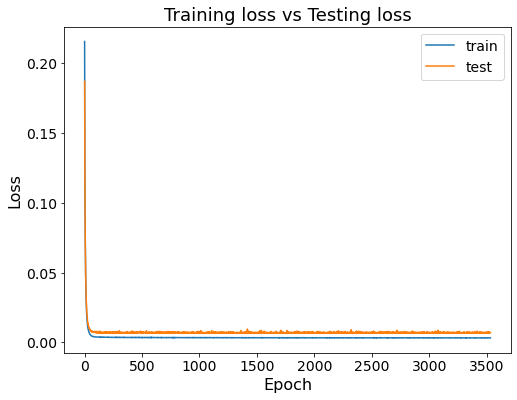

In [43]:
lr = 0.0001
EPOCHS = 6000

# initial_learning_rate * decay_rate ^ (step / decay_steps)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model_rnn.compile(
#     optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/rnn_shift_anyday_24h_4layer_sc.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_rnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [46]:
from tensorflow.keras.models import load_model
saved_model = load_model('saved_model/rnn_shift_anyday_24h_4layer_sc.h5')

In [47]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (8741, 24) (8741, 24)
(8741, 24)


In [48]:
### check out results here
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 31.909
RMSE = 50.953
